# Building a CNN Classifier with PyTorch: Part 2 

In this tutorial, we will expand "Building a CNN Classifier with PyTorch: Part 1" and introduce more advanced techniques that can be leveraged to optimize the performance of your CNN classifier model.  We will again be using data from [Design Safe](https://www.designsafe-ci.org/) in this tutorial, specifically a dataset from Hurricane Harvey, a category 4 hurricane that hit Texas in August of 2017 and resulted in catastrophic flooding to the Houston metropolitan area. The data set is specifically focused on image classification of homes according to the amount of damage the home received. All images of homes are labeled as C0, C2, or C4 respectively for low, medium or high damage.

Let's get started by importing the modules we need for this notebook as well as setting a few hyperparameters that are needed throughout the notebook. 

In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import os

torch.hub.set_dir('/tmp') # remove when not running here 

This notebook will use the same hyperparameters used in part 1:

- Learning Rate (lr): how much model parameters are updated at each batch/epoch
- Batch Size: number of data points used to estimate gradients at each iteration
- Epochs: Number of times to iterate over our entire dataset in optimization process

and are defined below. 

In [2]:
hp = {"lr":1e-4, "batch_size":16, "epochs":5}

## Dataset Loaders and Transforms

In Part1 of building a CNN Classifier, we introduced three Pytorch tools: 

- Dataset: stores data and their corresponding labels
- Transforms: performs data manipulation to make data suitable for training
- DataLoaders: iterable around the dataset for ease of access to samples from the dataset.

In this notebook, we will expand on additional transforms that can be done to improve performances of a CNN image classifier. 

### Downloading dataset
We first need to get our data set 

In [3]:
! cp -r /scratch1/07980/sli4/training/cnn_course/data/data.tar.gz /tmp/
! tar zxf /tmp/data.tar.gz -C /tmp
! ls /tmp/Dataset_2
! rm /tmp/data.tar.gz

Train  Validation


Next, let's define the path to train and validation sets based on the structure of the downloaded data.

In [4]:
train_path, val_path,test_path = "/tmp/Dataset_2/Train/", "/tmp/Dataset_2/Validation/", None

#### Transforms

In the previous notebook, we used `torchvision.transforms.Compose` to apply a series of transformations to our data. Compose performed a series of two transforms:

- `torchvision.transforms.Resize` which resizes your image to the specified dimension
- `torchvision.transforms.ToTensor` converts you images from PIL or numpy arrays to a torch tensor. 

Both of these transforms are for data preprocessing.  In data preprocessing, we are preparing data into the correct format for training (i.e. ensuring dimensionality of data is correct and in the correct format).  

However, Pytorch's data transforms is also used for data augmentation where new training examples are generated by applying various transforms to your existing data.  This helps to increase the size and diversity of your training set. There are several data augmentation techniques available in Pytorch. These techniques will perform operations like translating, rotating, and cropping images.  

In the new data loading pipeline in this notebook we will leverage a technique called [AutoAugment](https://arxiv.org/pdf/1805.09501.pdf).  This transform will augment images using a variety of augmentation techniques.  Throughout the optimization procedure, AutoAugment searches for an optimal policy for augmenting  images such that the performance of your model is optimized.  

Note `torchvision.transforms.AutoAugment()` only is applied for training data in the function below. 

In [5]:
def load_datasets(train_path, val_path, test_path):
  val_img_transform = transforms.Compose([transforms.Resize((244,244)),
                                         transforms.ToTensor()])
  #  Main Modification: Additional transformation
  train_img_transform = transforms.Compose([transforms.AutoAugment(),
                                          transforms.Resize((244,244)),
                                         transforms.ToTensor()])


  train_dataset = datasets.ImageFolder(train_path, transform=train_img_transform)
  val_dataset = datasets.ImageFolder(val_path, transform=val_img_transform) 
  test_dataset = datasets.ImageFolder(test_path, transform=val_img_transform) if test_path is not None else None
  print(f"Train set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")
  return train_dataset, val_dataset, test_dataset

In [6]:
train_set, val_set, test_set = load_datasets(train_path, val_path, test_path)

Train set size: 1322, Validation set size: 363


### Construct Dataloaders 

The data constructor is implemented in the same way as part 1 of this tutorial. 

In [7]:
def construct_dataloaders(train_set, val_set, test_set, batch_size, shuffle=True):
  train_dataloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle)
  val_dataloader = torch.utils.data.DataLoader(val_set, batch_size) 
  test_dataloader = torch.utils.data.DataLoader(test_set, batch_size) if test_path is not None else None
  return train_dataloader, val_dataloader, test_dataloader

In [8]:
train_dataloader, val_dataloader, test_dataloader = construct_dataloaders(train_set, val_set, test_set, hp["batch_size"], True)

### Visualizing the Augmented Design Safe Dataset

Before we move on to building the architecture of our CNN model, let's visualize some of our design safe dataset with the data augmentation strategy described above.  

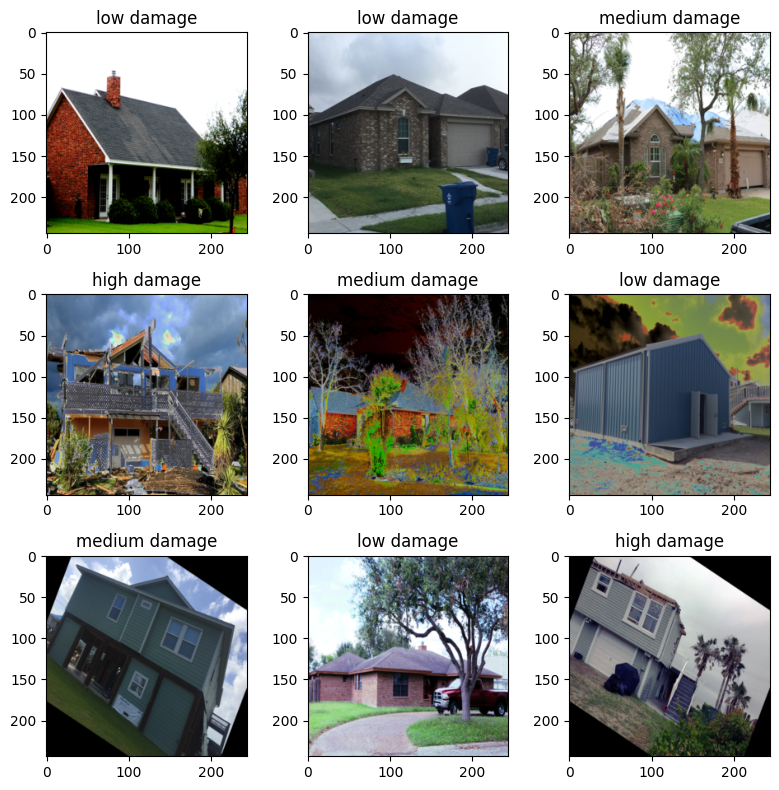

In [9]:
fig,axs = plt.subplots(3,3,figsize=(8, 8))
label_map={0: 'low damage', 1:'medium damage', 2:'high damage'}
for ax in axs.ravel():
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    ax.imshow(img.permute(1, 2, 0)) #.reshape((244,244,3)))
    ax.set_title(label_map[label])
fig.tight_layout()

As we can see above, our dataset contains images of houses post Hurricane Harvey.  Each of these images has been labeled as having low, medium, or high levels of damage.  These images have been modified in a variety of ways (rotating, pixels have changed, etc.) 

## Building the Neural Network 

### ResNet and Transfer Learning

Below we consolidate the code from part 1 of the tutorial into a function used to create the architecture of the network.  

Unlike part 1 of this tutorial, we will use a larger existing resnet model, resnet34, trained with the ImageNet dataset.  

In [10]:
def getResNet():
  resnet = models.resnet34(weights='IMAGENET1K_V1')

  # Fix the conv layers parameters
  for conv_param in resnet.parameters():
    conv_param.require_grad = False

  # get the input dimension for this layer
  num_ftrs = resnet.fc.in_features
    
  # build the new final mlp layers of network
  fc = nn.Sequential(
          nn.Linear(num_ftrs, num_ftrs),
          nn.ReLU(),
          nn.Linear(num_ftrs, 3)
        )
    
  # replace final fully connected layer
  resnet.fc = fc
  return resnet

In [11]:
resnet = getResNet()   

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /tmp/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 104MB/s] 


### Check for GPU and move model to correct device

As was done previously, we need to check if a gpu is available.  If a gpu is available, we will pass our model and data to the gpu to accelerate the calculations during the training process.  

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
resnet.to(device); # pass resnet model to gpu

## Training the Neural Network

### Define Loss Function and Optimizer

Now that we have our dataloaders set up and are model architecture built, we are ready to train our model.  To train the model, we need to set up a loss function and an optimizer to optimize that loss function.  Below we instantiate the Cross Entropy Loss function and the Adam optimizer as was done in part 1.  

There are two modifications made in the code below that can lead to improved performance: 

#### Label smoothing

Typically when performing classification we "one hot encode" the label we are trying to predict into a numerical representation that is typically integers. For example if we are predicting cats versus dogs in images, cats could represent 0 and dogs would be represented by 1.  The most helpful classifiers predict probabilities of an outcome.  That is, the model predicting 0.6 in the example above would mean there is a 60% chance that the image is a dog. 

Label smoothing is a regularization technique that introdcues some noise into the labels in our training data.  In label smoothing, we alter the numerical representations of our data to decrease the confidence that an an existing image is of a particular class in our training set.  A parameter called `label_smoothing`, or $\alpha$, controls how much we decrease the confidence an image is of a particular class via the following equation:

$$label_{soft}=label_{hard}(1-\alpha)+\frac{\alpha}{nc}$$

where nc is the number of classes being predicted in your classifier. Using the cat and dog classifier as an example and assuming we use a label_smoothing=0.1 we find the following new numerical representations of our labels.

$$label_{cat}=(0\times0.9)+\frac{0.1}{2}=0.05$$

$$label_{dog}=(1\times0.9)+\frac{0.1}{2}=0.95$$

#### Reduced learning rate on plateau

When optimizing neural networks, learning rates play a large role in the performance obtained of your model during training. Often times when training a deep learning model with a fixed learning rate, performance plateaus at a particular level. It is often advantageous to lower the learning rate at this point and see if any additional performance can be gained.  This technique was used in the original resnet paper and those results are highlighted below:

![](http://www.bdhammel.com/assets/learning-rate/resnet_loss.png)


There is a tool in pytorch -- `torch.optim.lr_scheduler.ReduceLROnPlateau` -- which automatically detects when a performance plateau has occurred and lowers the learning rate by the parameter `factor` after the plateau has been detected. 


Below we instantiate the optimizer, loss functions, and learning rate scheduler with techniques highlighted above.

In [14]:
# same optimizer used in part 1 of this tutorial
opt = torch.optim.Adam(resnet.parameters(),lr=hp["lr"])

# same loss function as part 1 except using label smoothing
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# adding a learning rate scheduler so that the learning rate can change throughout the optimization procedure
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                                    opt, mode='min', factor=0.1, patience=2, min_lr=1e-8, verbose=True
                                                        )

### Setting up Checkpoints

Training deep learning models can take a lot of computational power.  Additionally, you may not create an optimally performing model at the end of the training process.  For example, you may not initially select a sufficient number of epochs, have an underfit model, and need to resume your model training.  Conversely, you could select to many epochs and have a model that has overfit your data (See figure below)

<img src="images/fitting.png" width="500" height="300"  />

In either scenario, having a mechanism in place to save the models produced throughout the training process which result in high validation accuracy will help to ensure that you will not lose information gained throughout the training process. Throughout the rest of this notebook we will implement a process where we save our best performing model we have produced so far.

To implement this in our pipeline we first implement a function called `load_checkpoint` which will load a saved version of our model using `torch.load`. 

In [15]:
def load_checkpoint(checkpoint_path, DEVICE):
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE))
  return checkpoint

Then we create a directory, if it does not already exist, to store our model and define a file name intended to save our best model.

In [16]:
# For saving the trained model
model_folder_path = os.getcwd()+"/output_model/"
os.makedirs(model_folder_path,exist_ok=True)

# filename for our best model
checkpoint_file = model_folder_path+"best_model.pt"

As we may be resuming the training process with this code, we first check to see if a previously produced best model exists and load that model's performance (accuracy) and the model itself. 

In [17]:
# load the checkpoint that has the best performance in previous experiments
prev_best_val_acc = None
checkpoint_file = model_folder_path+"best_model.pt"
if os.path.exists(checkpoint_file):
  checkpoint = load_checkpoint(checkpoint_file, device)
  prev_best_val_acc = checkpoint['accuracy']

### Train and Model Evaluation Functions

Finally, we need to define standard pytorch train and evaluation functions.  The function `train` iterates over multiple epochs and all batches of data in each epoch.  Model parameters are updated for each batch with the given loss function and optimizer.  The model accuracy and loss is computing with testing data at every epoch.

There are two major modification made in this training loop compared to part 1:

1. We call the function `step` associated with `torch.optim.lr_scheduler.ReduceLROnPlateau` object instantiated earlier after each epoch.  This will check for validation loss plateaus.  If the plateaus are identified, the learning rate will be lowered

2. After each epoch we check to see if the validation accuracy of our model has improved.  If so we save the best performing model so far. To save the model we use `torch.save` which saves an object to disk. 

In [18]:
@torch.no_grad()
def eval_model(data_loader, model, loss_fn, DEVICE):
  model.eval()
  loss, accuracy = 0.0, 0.0
  n = len(data_loader)

  for i, data in enumerate(data_loader):
    x,y = data
    x,y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)
    loss += loss_fn(pred, y)/len(x)
    pred_label = torch.argmax(pred, axis = 1)
    accuracy += torch.sum(pred_label == y)/len(x)

  return loss/n, accuracy/n 

def train(train_loader, val_loader, model, opt, scheduler, loss_fn, epochs, DEVICE, checkpoint_file, prev_best_val_acc):
  n = len(train_loader)
  
  best_val_acc = torch.tensor(0.0).cuda() if prev_best_val_acc is None else prev_best_val_acc
    
  for epoch in range(epochs):
    model.train(True)
    
    avg_loss, val_loss, val_acc, avg_acc  = 0.0, 0.0, 0.0, 0.0
    
    start_time = datetime.now()
    
    for x, y in train_loader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      pred = model(x)
      loss = loss_fn(pred,y)

      opt.zero_grad()
      loss.backward()
      opt.step()

      avg_loss += loss.item()/len(x)
      pred_label = torch.argmax(pred, axis=1)
      avg_acc += torch.sum(pred_label == y)/len(x)

    val_loss, val_acc = eval_model(val_loader, model, loss_fn, DEVICE)
    
    end_time = datetime.now()
    
    total_time = torch.tensor((end_time-start_time).seconds).cuda()
    
    #######################################
    # Learning rate reducer takes action ##
    #######################################
    #opt.step()
    scheduler.step(val_loss)
    

    avg_loss, avg_acc = avg_loss/n, avg_acc/n
    
    #########################################################
    # Save the best model that has the highest val accuracy #
    #########################################################
    if val_acc.item() > best_val_acc.item():
      print(f"\nPrev Best Val Acc: {best_val_acc} < Cur Val Acc: {val_acc}")
      print("Saving the new best model...")
      
      #save the model with torch.save
      torch.save({
          'epoch':epoch,
          'model_state_dict':model.state_dict(),
          'accuracy': val_acc,
          'loss':val_loss
      }, checkpoint_file)
    
      best_val_acc = val_acc
      print("Finished saving model\n")
        
    # Print the metrics (should be same on all machines)
    print(f"\n(Epoch {epoch+1}/{epochs}) Time: {total_time}s")
    print(f"(Epoch {epoch+1}/{epochs}) Average train loss: {avg_loss}, Average train accuracy: {avg_acc}")
    print(f"(Epoch {epoch+1}/{epochs}) Val loss: {val_loss}, Val accuracy: {val_acc}")  
    print(f"(Epoch {epoch+1}/{epochs}) Current best val acc: {best_val_acc}\n")  


### Train Model 
Task:

Monitor Val accuracy vs. Train accuracy and check if overfitting exists.

In [ ]:
train(train_dataloader, val_dataloader, resnet, opt, scheduler,loss_fn, hp["epochs"], device, checkpoint_file, prev_best_val_acc)


Prev Best Val Acc: 0.0 < Cur Val Acc: 0.7025691270828247
Saving the new best model...
Finished saving model


(Epoch 1/5) Time: 414s
(Epoch 1/5) Average train loss: 0.05617035446037729, Average train accuracy: 0.5829819440841675
(Epoch 1/5) Val loss: 0.050685182213783264, Val accuracy: 0.7025691270828247
(Epoch 1/5) Current best val acc: 0.7025691270828247



###  OPTIONAL EXERCISE
In the demo above we trained ResNet34 model with data augmentation, label smoothing and learning rate reducer. Try to train the model without these techniques, and compare the training speed and performance. 

## We read back the best model and explore performance on various images

### Read the model checkpoint
We use load_model_fm_checkpoint to read back in the best model and load in the parameters from our training.

In [21]:
def load_checkpoint(checkpoint_path, DEVICE):
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
  return checkpoint

def load_model_fm_checkpoint(checkpoint, primitive_model, DEVICE):
  primitive_model.load_state_dict(checkpoint['model_state_dict'])
  return primitive_model.to(DEVICE)

def getResNet():
  resnet = models.resnet34(weights='IMAGENET1K_V1')

  # Fix the conv layers parameters
  for conv_param in resnet.parameters():
    conv_param.require_grad = False

  # get the input dimension for this layer
  num_ftrs = resnet.fc.in_features
    
  # build the new final mlp layers of network
  fc = nn.Sequential(
          nn.Linear(num_ftrs, num_ftrs),
          nn.ReLU(),
          nn.Linear(num_ftrs, 3)
        )
    
  # replace final fully connected layer
  resnet.fc = fc
  return resnet

In [22]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model_dump_dir = "./output_model/best_model.pt"
model = None

try:
    ckpt = load_checkpoint(model_dump_dir, DEVICE)
    model = load_model_fm_checkpoint(ckpt, getResNet(), DEVICE)
except FileNotFoundError: 
    print(f"{model_dump_dir} does not exist, please first train the model before performing inference!") 

###  Load in the dataset
In the function below, we use ImageFolder to load our testing data and perform the folloing two transformations: torchvision.transforms.Resize, torchvision.transofrms.ToTensor


In [23]:
def load_test_datasets(test_path):
  img_transform = transforms.Compose([transforms.Resize((244,244)),transforms.ToTensor()])
  try:
    test_dataset = datasets.ImageFolder(test_path, transform=img_transform) 
  except:
    print(f"test_path: {test_path} does not exist!")
  print(f"Test set size: {len(test_dataset)}")
  return test_dataset

In [24]:
# Please specify the path to train, cross_validation, and test images below:
test_path = "/tmp/Dataset_2/Validation/"
test_set = load_test_datasets(test_path)

Test set size: 363


### Perform inference on a random image
We can run inference on our model on a image to generate prediction. Let's run prediction and display the result. 

Tasks:
1. See if predictions match labels
2. Randomly choose images and run predictions

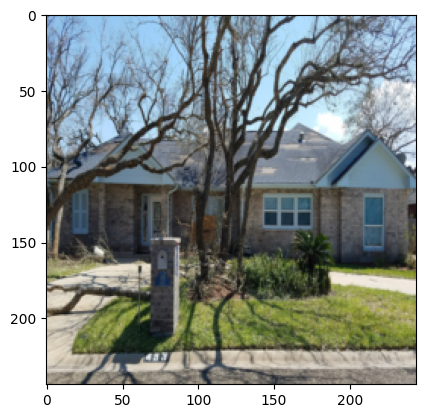

label: 1 for image_idx: tensor([[213]])
prediction result: 1 actual result: 1


In [34]:
random_idx = torch.randint(0, len(test_set), size=(1,1))
sample_image, label = test_set[random_idx]
plt.imshow(sample_image.permute(1,2,0))
plt.show()
print(f"label: {label} for image_idx: {random_idx}")

sample = sample_image.unsqueeze(0).to(DEVICE)

#make the prediction
prediction = torch.argmax(model(sample))

print(f"prediction result: {prediction} actual result: {label}")